In [13]:
import numpy as np 
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer, binarize
from copy import copy
from collections import Counter
import matplotlib.pyplot as plt 

# import counter
data_digits, label_digits = datasets.load_digits(return_X_y=True)
PCA_COMP =8
pca = PCA(n_components= PCA_COMP)

data_digits_reduced = pca.fit_transform(data_digits)

def mean_threshold_binarization(dat_):
    dat = copy(dat_)
    dat_mean = dat.mean()
    dat[dat >= dat_mean] = int(1) 
    dat[dat < dat_mean] = int(0)
    return dat 

to_bin = lambda data : ''.join(map(str, map(int, binarize([data], threshold= data.mean()).tolist()[0] )) )
data_digits_bin = [ to_bin(data) for data in data_digits_reduced ] 
# training_data = list(zip(data_digits_bin, label_digits))
from qumcmc.prob_dist import DiscreteProbabilityDistribution
from qumcmc.training import CDTraining
from qumcmc.energy_models import IsingEnergyFunction, random_ising_model
from qumcmc.mcmc_sampler_base import MCMCSampler, QuantumMCMCSampler, ClassicalMCMCSampler
from qumcmc.classical_mixers import *
from qumcmc.mixers import *

cal_gradvar = lambda TRAINING0 : [ (max(b[1]+b[0]), min(b[1]+b[0])) for b in TRAINING0.training_history['max-min-gradient'] ]

In [2]:
nspin = PCA_COMP
seed = 142248787
DATA = DiscreteProbabilityDistribution(Counter(data_digits_bin))
MODEL0 = random_ising_model(nspin, seed,)
BETA0= 1.0

In [27]:
CLSMIXER_UNIFORM = UniformProposals(nspin)
CLSAMPLER0 = ClassicalMCMCSampler(10, MODEL0, CLSMIXER_UNIFORM, name= 'CLSAMPLER0')

QMIXER_GENERIC = GenericMixer(nspin, int(nspin/2))
QSAMPLER0 = QuantumMCMCSampler(10, MODEL0, QMIXER_GENERIC, gamma= 0.5, verbose= False, name= 'QSAMPLER0')



# TRAINING0 = CDTraining(MODEL0, BETA0, DATA, name= 'mnist-v0')
# TRAINING1 = CDTraining(MODEL0, BETA0, DATA, name= 'mnist-v1')

In [50]:
TRAINING0.train(QSAMPLER0, 1000, epochs= 300, verbose= True)

training epochs: 100%|██████████| 300/300 [09:32<00:00,  1.91s/it, sampler=QSAMPLER0, update-strategy=all, kl div =0.463]


In [51]:
TRAINING1.train(CLSAMPLER0, 1000, epochs= 300, verbose= True)

training epochs: 100%|██████████| 300/300 [00:07<00:00, 37.91it/s, sampler=CLSAMPLER0, update-strategy=all, kl div =0.528]


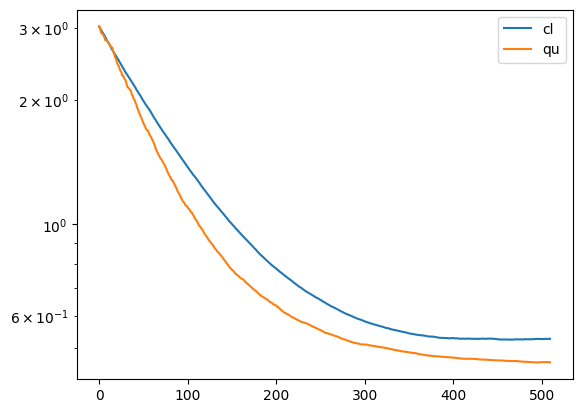

In [52]:
plt.plot(TRAINING1.training_history['kl_div'], label= 'cl')#, TRAINING0.training_history['kl_div'])
plt.plot(TRAINING0.training_history['kl_div'], label= 'qu')#, TRAINING0.training_history['kl_div'])
plt.yscale('log')
plt.legend()


In [10]:
TRAINING0.model == MODEL0

False